In [1]:
from itertools import product
import glob
import pickle

import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import NaturalEarthFeature
import xarray as xr
from scipy.ndimage import gaussian_filter
import datetime

import xesmf as xe
import metpy.calc as mpcalc
from minisom import MiniSom,asymptotic_decay
from collections import Counter
#import sklearn
#from sklearn.metrics import mean_squared_error

In [2]:
# reading in met table statistics
centers_filtered_new=pd.read_csv('filtered_centers_comet_144.csv')
centers_date_pd=pd.DataFrame(centers_filtered_new['date'])
centers_mask=centers_date_pd['date'].apply(lambda x: pd.to_datetime(str(x[:-7]), format='%Y%m%d'))
centers_filtered_new['fmt_date']=centers_mask

lon=centers_filtered_new['x']
lat=centers_filtered_new['y']

In [3]:
centers_filtered_new[(centers_filtered_new['case'].astype(str).str[0]=='F')&(np.isnan(centers_filtered_new['interest']))]

Unnamed: 0.1  Unnamed: 0  intersect    obs  forecast             date  \
3                4          14     -999.0 -999.0    -999.0  19851216_000000   
9               10          26     -999.0 -999.0    -999.0  19851228_000000   
20              23          56     -999.0 -999.0    -999.0  19860127_000000   
21              24          57     -999.0 -999.0    -999.0  19860128_000000   
23              27          63     -999.0 -999.0    -999.0  19860203_000000   
...            ...         ...        ...    ...       ...              ...   
1536          1625        3769     -999.0 -999.0    -999.0  20170121_000000   
1538          1627        3771     -999.0 -999.0    -999.0  20170123_000000   
1540          1630        3773     -999.0 -999.0    -999.0  20170125_000000   
1553          1646        3823     -999.0 -999.0    -999.0  20170316_000000   
1556          1649        3829     -999.0 -999.0    -999.0  20170322_000000   

      level_0  index          x         y  ... interest  area  bound_dist  \
3        1336      0 -138.34514  47.37789  ...      NaN   NaN         NaN   
9        1338      2 -136.55616  29.66671  ...      NaN   NaN         NaN   
20       1340      4 -134.89201  34.25638  ...      NaN   NaN         NaN   
21       1341      5 -139.24941  24.18238  ...      NaN   NaN         NaN   
23       1342      6 -156.68142  43.45281  ...      NaN   NaN         NaN   
...       ...    ...        ...       ...  ...      ...   ...         ...   
1536     1686    350 -125.01724  29.49631  ...      NaN   NaN         NaN   
1538     1688    352 -125.08756  32.65211  ...      NaN   NaN         NaN   
1540     1689    353 -137.71757  44.27022  ...      NaN   NaN         NaN   
1553     1691    355 -149.56203  31.68784  ...      NaN   NaN         NaN   
1556     1692   2241 -148.60860  33.23147  ...      NaN   NaN         NaN   

      percentile_90  centroid_dist     length  julian_date   real_date  \
3         730.88442            NaN  116.72616          350         NaN   
9         773.58131            NaN   77.71167          362         NaN   
20        797.10540            NaN  101.29009           27         NaN   
21        726.11353            NaN   62.51831           28         NaN   
23        728.41322            NaN   60.86167           34         NaN   
...             ...            ...        ...          ...         ...   
1536      707.10539            NaN   66.65252           21         NaN   
1538      692.34269            NaN   67.68022           23         NaN   
1540      700.04298            NaN   94.91357           25         NaN   
1553      698.83145            NaN  101.46987           75         NaN   
1556      838.25831            NaN   80.04509           81  2017-03-22   

        ddif   fmt_date  
3        NaN 1985-12-16  
9        NaN 1985-12-28  
20       NaN 1986-01-27  
21       NaN 1986-01-28  
23       NaN 1986-02-03  
...      ...        ...  
1536     NaN 2017-01-21  
1538     NaN 2017-01-23  
1540     NaN 2017-01-25  
1553     NaN 2017-03-16  
1556  5 days 2017-03-22  

[276 rows x 24 columns]

In [4]:
centers_filtered_new.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'intersect', 'obs', 'forecast', 'date',
       'level_0', 'index', 'x', 'y', 'case', 'fcsthr', 'met_x', 'met_y',
       'interest', 'area', 'bound_dist', 'percentile_90', 'centroid_dist',
       'length', 'julian_date', 'real_date', 'ddif', 'fmt_date'],
      dtype='object')

In [5]:
centers_filtered_new['intersect']=centers_filtered_new['intersect'].replace(-999.0, np.nan)
centers_filtered_new['obs']=centers_filtered_new['obs'].replace(-999.0, np.nan)
centers_filtered_new['forecast']=centers_filtered_new['forecast'].replace(-999.0, np.nan)

In [6]:
centers_filtered_new['moe_x']=centers_filtered_new['intersect'].div((centers_filtered_new['obs'].values))
centers_filtered_new['moe_y']=centers_filtered_new['intersect'].div((centers_filtered_new['forecast'].values))
centers_filtered_new['dist']=np.sqrt(((1-centers_filtered_new['moe_x'])**2) + ((1-centers_filtered_new['moe_y'])**2))

In [7]:
Fa=np.where((centers_filtered_new['case'].astype(str).str[0]=='F')&(np.isnan(centers_filtered_new['interest']))
   | (centers_filtered_new['case'].astype(str).str[0]=='O'))

In [8]:
centers_miss_fa=centers_filtered_new.iloc[Fa]
justfa=np.where((centers_filtered_new['case'].astype(str).str[0]=='F')&(np.isnan(centers_filtered_new['interest'])))
justm=np.where((centers_filtered_new['case'].astype(str).str[0]=='O'))
centers_miss=centers_filtered_new.iloc[justm]
centers_fa=centers_filtered_new.iloc[justfa]

In [9]:
centers_miss

Unnamed: 0.1  Unnamed: 0  intersect  obs  forecast             date  \
12              13          35        NaN  NaN       NaN  19860106_000000   
19              22          49        NaN  NaN       NaN  19860120_000000   
25              29          66        NaN  NaN       NaN  19860206_000000   
26              31          68        NaN  NaN       NaN  19860208_000000   
30              36          88        NaN  NaN       NaN  19860228_000000   
...            ...         ...        ...  ...       ...              ...   
1515          1600        3705        NaN  NaN       NaN  20160318_000000   
1516          1601        3709        NaN  NaN       NaN  20160322_000000   
1529          1616        3752        NaN  NaN       NaN  20170104_000000   
1544          1635        3789        NaN  NaN       NaN  20170210_000000   
1550          1643        3812        NaN  NaN       NaN  20170305_000000   

      level_0  index          x         y  ... percentile_90  centroid_dist  \
12       1693      0 -149.51576  34.33580  ...     779.04933            NaN   
19       1695      2 -155.62799  37.42371  ...     987.67998            NaN   
25       1699      6 -152.32435  38.21643  ...     722.05315            NaN   
26       1701      8 -149.89673  43.01016  ...     633.18504            NaN   
30       1704     11 -153.95398  27.49405  ...     904.86802            NaN   
...       ...    ...        ...       ...  ...           ...            ...   
1515     2241    548 -142.46947  47.90894  ...     622.85694            NaN   
1516     2242   2180 -155.31235  41.68885  ...    1114.39414            NaN   
1529     2243   2197 -129.57880  24.55512  ...     620.64849            NaN   
1544     2246    553 -125.94009  32.45138  ...     712.83862            NaN   
1550     2247   2234 -155.22591  32.82037  ...     830.36329            NaN   

         length  julian_date   real_date     ddif   fmt_date  moe_x  moe_y  \
12     76.76277            6         NaN      NaN 1986-01-06    NaN    NaN   
19     63.92847           20         NaN      NaN 1986-01-20    NaN    NaN   
25     93.78916           37         NaN      NaN 1986-02-06    NaN    NaN   
26     62.39147           39         NaN      NaN 1986-02-08    NaN    NaN   
30     57.58063           59         NaN      NaN 1986-02-28    NaN    NaN   
...         ...          ...         ...      ...        ...    ...    ...   
1515  117.35705           78         NaN      NaN 2016-03-18    NaN    NaN   
1516   65.77383           82  2016-03-22   9 days 2016-03-22    NaN    NaN   
1529   57.18339            4  2017-01-04  16 days 2017-01-04    NaN    NaN   
1544   68.12324           41         NaN      NaN 2017-02-10    NaN    NaN   
1550   76.07516           64  2017-03-05  15 days 2017-03-05    NaN    NaN   

      dist  
12     NaN  
19     NaN  
25     NaN  
26     NaN  
30     NaN  
...    ...  
1515   NaN  
1516   NaN  
1529   NaN  
1544   NaN  
1550   NaN  

[432 rows x 27 columns]

In [10]:
centers_miss['case'][centers_miss['fmt_date']=='1987-12-23']

119    O001
Name: case, dtype: object

In [11]:
centers_mask=~centers_filtered_new['fmt_date'].isin(centers_miss_fa['fmt_date'])
centers_nonmatch=centers_filtered_new['fmt_date'].isin(centers_miss_fa['fmt_date'])


centers_matched=centers_filtered_new[centers_mask]
centers_unmatch=centers_filtered_new[centers_nonmatch]

In [12]:
lon_match=centers_matched['x']
lat_match=centers_matched['y']

lon_unmatch=centers_unmatch['x']
lat_unmatch=centers_unmatch['y']

In [13]:
diff_unmatched=xr.open_dataset('diff_final_unmatched.nc')

In [14]:
diff_matched=xr.open_dataset('diff_matched.nc')

In [15]:
diff_all=xr.concat([diff_matched['variable'], diff_unmatched['variable']],dim='time')

In [16]:
diff_all

<xarray.DataArray 'variable' (time: 1547, y: 56, x: 56)>
array([[[-399.74391302, -368.81664654, -327.12626836, ...,
          -54.02890712,  -39.61540742,  -19.47593987],
        [-425.13360859, -401.27830163, -355.72374531, ...,
          -33.79069638,  -11.42047563,   26.00491508],
        [-452.77466258, -424.68288867, -386.74788558, ...,
          -23.68501706,    5.95708371,   48.52066703],
        ...,
        [ -88.79403498, -106.053879  , -122.56472512, ...,
         -179.85616866, -167.66523526, -158.2482431 ],
        [ -94.96095404, -108.31313773, -133.79578082, ...,
         -166.92755156, -156.31047229, -140.70783335],
        [ -94.98057721, -110.8039548 , -144.5169514 , ...,
         -166.41355739, -145.57946058, -126.43582237]],

       [[-134.35164718,  -78.38426716, -117.73423582, ...,
          140.82463417,  136.49448411,  122.84395474],
        [-217.26188261, -144.56404276, -145.51783739, ...,
          161.75854457,  147.16315604,  134.7482669 ],
        [-325.95887046, -241.61036971, -186.98593448, ...,
          161.11350241,  142.68515318,  109.22923697],
...
        [  67.24616159,   74.82689049,   93.60286769, ...,
           32.4829946 ,   34.11368731,   37.21833334],
        [ 107.1146679 ,  109.12624877,  121.31793275, ...,
           38.07372829,   36.51925429,   35.77443071],
        [ 137.16297236,  132.98347464,  140.34381047, ...,
           46.75760684,   43.84363458,   43.88006571]],

       [[ 105.51112414,  105.54453385,  105.20691418, ...,
          -68.41322461,  -76.99109468,  -86.89258841],
        [ 107.86981608,  109.20584375,  110.66443864, ...,
          -50.96919001,  -66.57629458,  -79.85252342],
        [ 111.27576368,  112.78691137,  114.47925569, ...,
          -43.46622678,  -55.19237723,  -69.12772521],
        ...,
        [  -6.89334729,  -15.65216466,  -27.10515194, ...,
          107.93175695,  119.11261963,  134.9782835 ],
        [ -18.00199605,    3.89272441,   12.91855856, ...,
           96.12792501,  102.09541452,  108.71023614],
        [  14.88353201,   18.99652126,   18.59648553, ...,
           83.17143306,   82.70931065,   82.25823888]]])
Coordinates:
    lon      (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat      (time, x) float64 35.0 35.25 35.5 35.75 ... 39.25 39.5 39.75 40.0
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-22
Dimensions without coordinates: y, x

In [17]:
# diff_all.to_netcdf('totalcases1547_144.nc')

In [18]:
diff_all

<xarray.DataArray 'variable' (time: 1547, y: 56, x: 56)>
array([[[-399.74391302, -368.81664654, -327.12626836, ...,
          -54.02890712,  -39.61540742,  -19.47593987],
        [-425.13360859, -401.27830163, -355.72374531, ...,
          -33.79069638,  -11.42047563,   26.00491508],
        [-452.77466258, -424.68288867, -386.74788558, ...,
          -23.68501706,    5.95708371,   48.52066703],
        ...,
        [ -88.79403498, -106.053879  , -122.56472512, ...,
         -179.85616866, -167.66523526, -158.2482431 ],
        [ -94.96095404, -108.31313773, -133.79578082, ...,
         -166.92755156, -156.31047229, -140.70783335],
        [ -94.98057721, -110.8039548 , -144.5169514 , ...,
         -166.41355739, -145.57946058, -126.43582237]],

       [[-134.35164718,  -78.38426716, -117.73423582, ...,
          140.82463417,  136.49448411,  122.84395474],
        [-217.26188261, -144.56404276, -145.51783739, ...,
          161.75854457,  147.16315604,  134.7482669 ],
        [-325.95887046, -241.61036971, -186.98593448, ...,
          161.11350241,  142.68515318,  109.22923697],
...
        [  67.24616159,   74.82689049,   93.60286769, ...,
           32.4829946 ,   34.11368731,   37.21833334],
        [ 107.1146679 ,  109.12624877,  121.31793275, ...,
           38.07372829,   36.51925429,   35.77443071],
        [ 137.16297236,  132.98347464,  140.34381047, ...,
           46.75760684,   43.84363458,   43.88006571]],

       [[ 105.51112414,  105.54453385,  105.20691418, ...,
          -68.41322461,  -76.99109468,  -86.89258841],
        [ 107.86981608,  109.20584375,  110.66443864, ...,
          -50.96919001,  -66.57629458,  -79.85252342],
        [ 111.27576368,  112.78691137,  114.47925569, ...,
          -43.46622678,  -55.19237723,  -69.12772521],
        ...,
        [  -6.89334729,  -15.65216466,  -27.10515194, ...,
          107.93175695,  119.11261963,  134.9782835 ],
        [ -18.00199605,    3.89272441,   12.91855856, ...,
           96.12792501,  102.09541452,  108.71023614],
        [  14.88353201,   18.99652126,   18.59648553, ...,
           83.17143306,   82.70931065,   82.25823888]]])
Coordinates:
    lon      (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat      (time, x) float64 35.0 35.25 35.5 35.75 ... 39.25 39.5 39.75 40.0
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-22
Dimensions without coordinates: y, x

In [19]:
diff_all['time']

<xarray.DataArray 'time' (time: 1547)>
array(['1985-12-08T00:00:00.000000000', '1985-12-10T00:00:00.000000000',
       '1985-12-11T00:00:00.000000000', ..., '2017-03-05T00:00:00.000000000',
       '2017-03-16T00:00:00.000000000', '2017-03-22T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-22

In [20]:
diff_all_final=diff_all.sortby('time')

In [21]:
diff_all_final['time']

<xarray.DataArray 'time' (time: 1547)>
array(['1985-12-08T00:00:00.000000000', '1985-12-10T00:00:00.000000000',
       '1985-12-11T00:00:00.000000000', ..., '2017-03-28T00:00:00.000000000',
       '2017-03-29T00:00:00.000000000', '2017-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31

In [22]:
miss_mask=centers_miss['fmt_date'].isin(pd.to_datetime(diff_all_final['time']))
fa_mask=centers_fa['fmt_date'].isin(pd.to_datetime(diff_all_final['time']))

In [23]:
centers_miss['fmt_date'][miss_mask]

12     1986-01-06
19     1986-01-20
25     1986-02-06
26     1986-02-08
30     1986-02-28
          ...    
1515   2016-03-18
1516   2016-03-22
1529   2017-01-04
1544   2017-02-10
1550   2017-03-05
Name: fmt_date, Length: 427, dtype: datetime64[ns]

In [24]:
diff_all['lon'].shape

(56,)

In [25]:
miss_new=xr.Dataset({'variable': (['time'],centers_miss['fmt_date'][miss_mask])},
             coords={"lon":(["y"],diff_unmatched['lon'].values), #should change to lonlist/latlist 
                     "lat":(["x"],diff_unmatched['lat'].values),
                    "time":(["time"],centers_miss['fmt_date'][miss_mask])})

In [26]:
fa_new=xr.Dataset({'variable': (['time'],centers_fa['fmt_date'][fa_mask])},
             coords={"lon":(["y"],diff_unmatched['lon'].data), #should change to lonlist/latlist 
                     "lat":(["x"],diff_unmatched['lat'].data),
                    "time":(["time"],centers_fa['fmt_date'][fa_mask])})

In [27]:
miss_new

<xarray.Dataset>
Dimensions:   (time: 427, y: 56, x: 56)
Coordinates:
    lon       (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat       (x) float64 26.25 26.5 26.75 27.0 27.25 ... 39.25 39.5 39.75 40.0
  * time      (time) datetime64[ns] 1986-01-06 1986-01-20 ... 2017-03-05
Dimensions without coordinates: y, x
Data variables:
    variable  (time) datetime64[ns] 1986-01-06 1986-01-20 ... 2017-03-05

In [28]:
fa_new

<xarray.Dataset>
Dimensions:   (time: 271, y: 56, x: 56)
Coordinates:
    lon       (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat       (x) float64 26.25 26.5 26.75 27.0 27.25 ... 39.25 39.5 39.75 40.0
  * time      (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-22
Dimensions without coordinates: y, x
Data variables:
    variable  (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-22

In [29]:
smooth_fcst=xr.open_dataset('fcst_unmatched.nc')
smooth_obs=xr.open_dataset('obs_unmatched.nc')
match_obs=xr.open_dataset('obs_matched.nc')
match_fcst=xr.open_dataset('fcst_matched.nc')

In [30]:
all_fcst=xr.concat([smooth_fcst,match_fcst],dim='time')

In [31]:
all_obs=xr.concat([smooth_obs,match_obs],dim='time')

In [32]:
all_fcst

<xarray.Dataset>
Dimensions:                        (time: 1547, y: 56, x: 56)
Coordinates:
    lon                            (time, y) float32 -145.2 -145.0 ... -141.8
    lat                            (time, x) float32 40.5 40.75 ... 48.5 48.75
  * time                           (time) datetime64[ns] 1985-12-16 ... 2017-...
Dimensions without coordinates: y, x
Data variables:
    __xarray_dataarray_variable__  (time, x, y) float64 0.9454 0.9214 ... 1.0

In [33]:
landfall=pd.read_csv('WC-Landfalling-AR-Events-Master-10-19.csv')

In [34]:
landfall

Event Start    Event Dur    maxScale    maxLocDur      maxIVT  maxIVTLat  \
0     2009101306          120           5          108        1007         37   
1     2009102300           18           1           18         689         48   
2     2009102518           12           1           12         574         47   
3     2009102806           78           2           42         731         48   
4     2009110506           24           2           24         640         44   
..           ...          ...         ...          ...         ...        ...   
248   2019022418           78           3           54         708         37   
249   2019030112           24           1           24         513         35   
250   2019040506           60           3           60         731         44   
251   2019041806           24           2           24         508         47   
252   2019042212           12           1           12         536         48   

     maxScaletime   Type  
0      2009101306   Ncyc  
1      2009102306   Ncyc  
2      2009102518   Ncyc  
3      2009102912   Scyc  
4      2009110506   Ncyc  
..            ...    ...  
248    2019022600  NDcyc  
249    2019030118   Ncyc  
250    2019040506  NDcyc  
251    2019041806   Ncyc  
252    2019042212   Ncyc  

[253 rows x 8 columns]

In [35]:
landfmt=landfall['Event Start'].apply(lambda x :str(x)[0:4]+'-'+str(x)[4:6]+'-'+str(x)[6:8])

In [36]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [37]:
# lr_arr=[.1]
# sigma_arr=[2]

In [38]:
lr_arr=[.01]
sigma_arr=[2]

In [39]:
diff_stack=diff_all_final.stack(new=('y','x'))

In [40]:
matched_ivt=xr.open_dataset('wwrfss_matched_final.nc')

In [41]:
matched_ivt

<xarray.Dataset>
Dimensions:   (time: 851, x: 56, y: 56)
Coordinates:
    lon       (time, y) float64 ...
    lat       (time, x) float64 ...
  * time      (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: x, y
Data variables:
    variable  (time, x, y) float64 ...

In [42]:
unmatched_ivt=xr.open_dataset('regridwrfss_unmatched.nc')

In [43]:
unmatched_ivt

<xarray.Dataset>
Dimensions:   (time: 698, x: 56, y: 56)
Coordinates:
    lon       (time, y) float64 ...
    lat       (time, x) float64 ...
  * time      (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-22
Dimensions without coordinates: x, y
Data variables:
    variable  (time, x, y) float64 ...

In [44]:
miss_mask=unmatched_ivt['time'].isin(miss_new['time'])

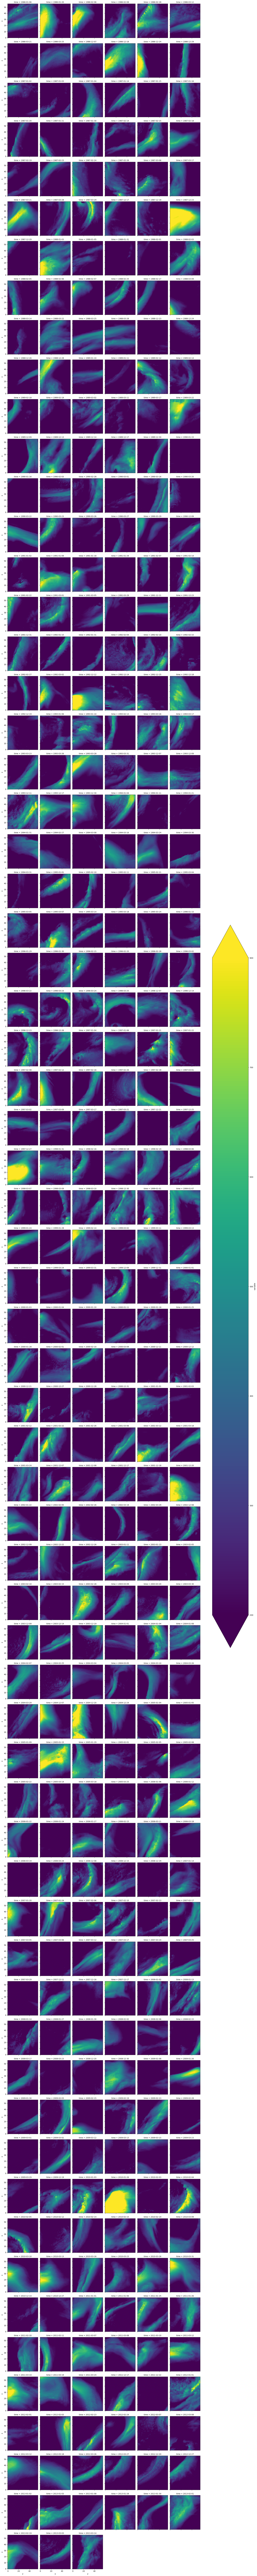

In [45]:
unmatched_ivt['variable'][miss_mask][:-40].plot(vmin=200,vmax=800,col='time',col_wrap=6)

In [46]:
ht_match=xr.open_dataset('ht_matched_final.nc')

In [47]:
ht_match

<xarray.Dataset>
Dimensions:   (y: 56, x: 56, time: 849)
Coordinates:
    lon       (y) float64 ...
    lat       (x) float64 ...
  * time      (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time, y, x) float64 ...

In [48]:
ht_unmatch=xr.open_dataset('ht_unmatch.nc')

In [49]:
ht_unmatch

<xarray.Dataset>
Dimensions:   (time: 698, y: 56, x: 56)
Coordinates:
    lon       (y) float64 ...
    lat       (x) float64 ...
  * time      (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-22
Dimensions without coordinates: y, x
Data variables:
    variable  (time, y, x) float64 ...

In [50]:
ht_all=xr.concat([ht_unmatch['variable'], ht_match['variable']],dim='time')

In [51]:
ht_all

<xarray.DataArray 'variable' (time: 1547, y: 56, x: 56)>
array([[[5675.9453125 , 5679.4296875 , 5683.39990234, ...,
         5785.18261719, 5785.60888672, 5785.87744141],
        [5671.31201172, 5675.29882812, 5679.26806641, ...,
         5783.03417969, 5783.52490234, 5783.85009766],
        [5665.62695312, 5669.98974609, 5674.16015625, ...,
         5780.93847656, 5781.30566406, 5781.76318359],
        ...,
        [5292.40478516, 5296.12646484, 5299.79785156, ...,
         5541.14746094, 5543.47949219, 5545.45751953],
        [5286.86523438, 5290.59716797, 5294.19482422, ...,
         5534.26464844, 5536.66015625, 5538.45800781],
        [5280.90966797, 5284.47705078, 5288.43505859, ...,
         5527.03076172, 5528.98925781, 5530.58642578]],

       [[5770.64892578, 5771.52099609, 5772.60888672, ...,
         5833.16015625, 5833.65234375, 5834.34375   ],
        [5767.22900391, 5768.25341797, 5769.18212891, ...,
         5831.9296875 , 5832.74609375, 5833.49072266],
        [5763.53027344, 5764.38623047, 5765.4765625 , ...,
         5830.44726562, 5831.72802734, 5832.48779297],
...
        [5376.0390625 , 5378.13867188, 5380.36279297, ...,
         5584.90869141, 5587.09960938, 5589.15576172],
        [5374.95410156, 5377.06054688, 5379.17822266, ...,
         5576.1875    , 5578.42089844, 5580.75488281],
        [5374.54394531, 5376.51904297, 5378.42919922, ...,
         5568.15478516, 5570.50683594, 5573.11914062]],

       [[5775.18261719, 5779.02832031, 5782.53515625, ...,
         5878.22753906, 5878.55517578, 5878.93359375],
        [5768.23388672, 5772.69824219, 5776.29248047, ...,
         5876.46289063, 5876.640625  , 5876.69970703],
        [5762.07177734, 5765.82568359, 5770.19140625, ...,
         5874.28027344, 5874.48779297, 5874.73193359],
        ...,
        [5308.05615234, 5312.28564453, 5316.70166016, ...,
         5650.38427734, 5654.68554688, 5657.47216797],
        [5303.234375  , 5307.11181641, 5311.22851562, ...,
         5643.94921875, 5647.13378906, 5650.52978516],
        [5298.48876953, 5302.00878906, 5305.76611328, ...,
         5636.234375  , 5639.85644531, 5643.77783203]]])
Coordinates:
    lon      (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat      (time, x) float64 26.25 26.5 26.75 27.0 ... 48.0 48.25 48.5 48.75
  * time     (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-31
Dimensions without coordinates: y, x

In [52]:
ivt_all=xr.concat([matched_ivt['variable'], unmatched_ivt['variable']],dim='time')

In [53]:
mask_ivt=ivt_all['time'].isin(diff_stack['time'])

In [54]:
mask_ivt

<xarray.DataArray 'time' (time: 1549)>
array([ True,  True,  True, ...,  True,  True,  True])
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-22

In [55]:
ivt_final=ivt_all[mask_ivt]

(array([1.181936e+06, 1.567972e+06, 1.061515e+06, 6.750920e+05,
        2.634820e+05, 7.655700e+04, 2.043100e+04, 4.049000e+03,
        3.400000e+02, 1.800000e+01]),
 array([3.97766471e-01, 1.90321308e+02, 3.80244849e+02, 5.70168390e+02,
        7.60091931e+02, 9.50015473e+02, 1.13993901e+03, 1.32986256e+03,
        1.51978610e+03, 1.70970964e+03, 1.89963318e+03]),
 <BarContainer object of 10 artists>)

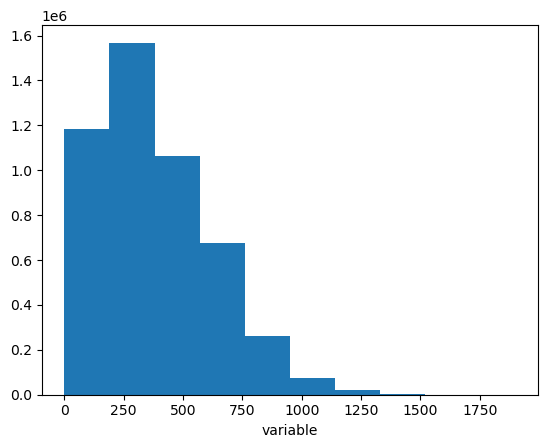

In [56]:
ivt_final.plot()

In [57]:
# ivt_final.to_netcdf('ivt_final_total144.nc')

In [58]:
# ivt_final=xr.open_dataset('ivt_final_total144.nc')

In [59]:
ivt_plot=ivt_final.stack(new=('y','x'))

In [60]:
ivt_plot

<xarray.DataArray 'variable' (time: 1547, new: 3136)>
array([[192.76066589, 193.84796143, 184.33732605, ..., 104.99869537,
        116.26673889, 123.25020599],
       [486.93515015, 489.77468872, 452.19024658, ..., 709.9050293 ,
        671.00097656, 661.40924072],
       [ 96.930336  ,  92.1741333 , 104.75239563, ..., 127.55202484,
        124.37425995, 118.9688797 ],
       ...,
       [291.0486145 , 224.86082458, 195.7510376 , ...,  28.70635796,
         24.43387604,  21.85643959],
       [150.21469116, 174.84091187, 199.13194275, ..., 218.45788574,
        201.20530701, 192.46633911],
       [168.13064575, 191.22833252, 217.91569519, ..., 260.39205933,
        232.91664124, 205.08625793]])
Coordinates:
    lon      (time, new) float64 -159.5 -159.5 -159.5 ... -141.8 -141.8 -141.8
    lat      (time, new) float64 30.25 30.5 30.75 31.0 ... 39.25 39.5 39.75 40.0
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-22
  * new      (new) object MultiIndex
  * y        (new) int64 0 0 0 0 0 0 0 0 0 0 0 ... 55 55 55 55 55 55 55 55 55 55
  * x        (new) int64 0 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54 55

In [61]:
ivt_plot_new=xr.open_dataset('allivt_oldscript.nc')

In [62]:
ht_all_new=xr.open_dataset('allht_oldscript.nc')

In [63]:
ht_all_new

<xarray.Dataset>
Dimensions:   (time: 1551, y: 200, x: 200)
Coordinates:
    lon       (y, x) float32 ...
    lat       (y, x) float32 ...
  * time      (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time, y, x) float32 ...

In [64]:
ivt_plot_new

<xarray.Dataset>
Dimensions:   (time: 1551, y: 200, x: 200)
Coordinates:
    lon       (y, x) float32 ...
    lat       (y, x) float32 ...
  * time      (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time, y, x) float32 ...

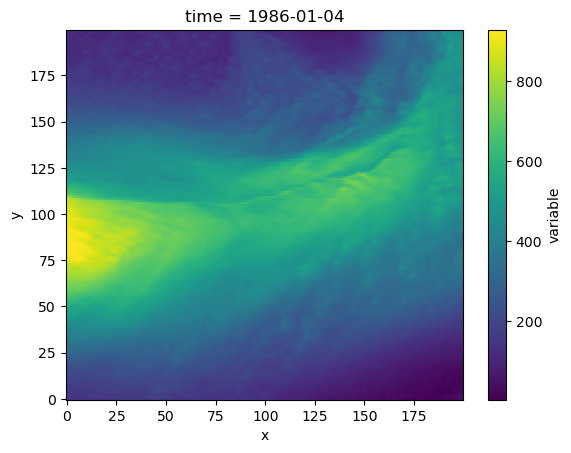

In [65]:
ivt_plot_new['variable'].sel(time='1986-01-04').plot()

In [66]:
ht_all_new.time

<xarray.DataArray 'time' (time: 1551)>
array(['1985-12-08T00:00:00.000000000', '1985-12-10T00:00:00.000000000',
       '1985-12-11T00:00:00.000000000', ..., '2017-03-28T00:00:00.000000000',
       '2017-03-29T00:00:00.000000000', '2017-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31

In [67]:
ivt_plot_new.time

<xarray.DataArray 'time' (time: 1551)>
array(['1985-12-08T00:00:00.000000000', '1985-12-10T00:00:00.000000000',
       '1985-12-11T00:00:00.000000000', ..., '2017-03-28T00:00:00.000000000',
       '2017-03-29T00:00:00.000000000', '2017-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31

In [68]:
dates_ds1 = pd.to_datetime(ivt_plot_new.time.values)
dates_ds2 = pd.to_datetime(diff_stack.time.values)

# Find the date that is present in ds1 but missing in ds2
missing_date = set(dates_ds1) - set(dates_ds2)

# Convert the result back to a datetime object
missing_date = min(missing_date)

# Print or use the missing date
print("Missing Date:", missing_date)

Missing Date: 1986-01-04 00:00:00


In [69]:
mask_ivt_new=ivt_plot_new['time'].isin(diff_stack['time'])

In [70]:
ivt_plot_final=ivt_plot_new['variable'][mask_ivt_new].stack(new=('y','x'))

In [71]:
ht_plot_final=ht_all_new['variable'][mask_ivt_new]#.stack(new=('y','x'))

In [72]:
mask_diff=diff_stack['time'].isin(ivt_plot_final['time'])

In [73]:
diff_stack[mask_diff]['time']

<xarray.DataArray 'time' (time: 1546)>
array(['1985-12-08T00:00:00.000000000', '1985-12-10T00:00:00.000000000',
       '1985-12-11T00:00:00.000000000', ..., '2017-03-28T00:00:00.000000000',
       '2017-03-29T00:00:00.000000000', '2017-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31

In [74]:
ht_plot_final['time']

<xarray.DataArray 'time' (time: 1546)>
array(['1985-12-08T00:00:00.000000000', '1985-12-10T00:00:00.000000000',
       '1985-12-11T00:00:00.000000000', ..., '2017-03-28T00:00:00.000000000',
       '2017-03-29T00:00:00.000000000', '2017-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31

In [75]:
ivt_plot_final

<xarray.DataArray 'variable' (time: 1546, new: 40000)>
array([[369.49872 , 368.11285 , 363.63428 , ...,  68.44835 ,  70.35797 ,
         71.865074],
       [618.8466  , 641.7234  , 644.14526 , ..., 456.22314 , 454.5591  ,
        451.78058 ],
       [184.70569 , 184.21721 , 184.3625  , ...,  72.542885,  71.60971 ,
         70.57071 ],
       ...,
       [272.5851  , 271.60776 , 269.25867 , ..., 417.79132 , 422.42358 ,
        426.44443 ],
       [372.00952 , 398.4855  , 421.45914 , ..., 103.02129 , 105.13366 ,
        107.58952 ],
       [562.8751  , 559.916   , 556.0896  , ..., 537.71075 , 529.61597 ,
        520.1847  ]], dtype=float32)
Coordinates:
    lon      (new) float32 -156.3 -156.2 -156.1 -156.0 ... -138.3 -138.1 -138.0
    lat      (new) float32 32.52 32.54 32.56 32.58 ... 50.93 50.93 50.93 50.94
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
  * new      (new) object MultiIndex
  * y        (new) int64 0 0 0 0 0 0 0 0 0 ... 199 199 199 199 199 199 199 199
  * x        (new) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199

In [76]:
# # quant_list=[]
# # topo_list=[]
# # dict_sl={}
# #for l in lr_arr:
# for l in lr_arr:
    
#     for s in sigma_arr:
    
#             print(s)

#             som_grid_rows = 4         # (y-axis)
#             som_grid_columns = 4     # (x-axis)
#             input_length = ivt_plot_final.shape[1]    # using preprocessed data array; Number of the elements of the vectors in input.
#             sigma = s#4x4 sigma of 3,3x3 sigma of 2            # Spread of the neighborhood function, needs to be adequate to the dimensions of the map.
#             learning_rate = l       # initial learning rate (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
#             decay_function = asymptotic_decay

#             """Function that reduces learning_rate and sigma at each iteration
#             the default function is (asymptotic_decay):
#                 learning_rate / (1+t/(max_iterarations/2))

#             A custom decay function will need to to take in input
#             three parameters in the following order:

#             1. learning rate
#             2. current iteration
#             3. maximum number of iterations allowed

#             Note that if a lambda function is used to define the decay
#             MiniSom will not be pickable anymore."""

#             neighborhood_function = 'gaussian'

#             """Function that weights the neighborhood of a position in the map. 
#             Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle', 
#             which takes in sigma."""

#             topology = 'rectangular'                 # Topology of the map; Possible values: 'rectangular', 'hexagonal'
#             activation_distance = 'euclidean'        # Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
#             random_seed = 1 #run a few times with different seed =2,3 etc to prove consistency 


#             newsom = MiniSom(
#             som_grid_rows,
#             som_grid_columns,
#             input_length,
#             sigma,
#             learning_rate,
#             decay_function,
#             neighborhood_function,
#             topology,
#             activation_distance,
#             random_seed)

    
            

#             data2 = normalize_data(ivt_plot_final)
#             #data2 = subsetarray
#             num_iteration = 20000 #try decreasing to 10,000 to dec training time
#             random_order = True #keep True
#             verbose = True
#             data2.shape
            
#             newsom.random_weights_init(data2.values)    # random method
#             print(newsom.random_weights_init(data2.values))

#             ### train som ###
#             newsom.train(
#             data2.values,
#             num_iteration,
#             random_order,
#             verbose  
#             )

# #             quant_list.append(newsom.quantization_error(data2))
# #             topo_list.append(newsom.topographic_error(data2))
# #             dict_sl = {key: (newsom.quantization_error(data2),newsom.topographic_error(data2),\
# #                             (newsom.quantization_error(data2)+newsom.topographic_error(data2))) for key in listsl}
            

#             plt.figure(figsize=(10, 9))
#             cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
#             plt.title("distance map of the ivt", fontsize=12)
#             plt.colorbar(cs)
#             plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
#             plt.show()


#             # this may take a few minutes if lots of data! currently doing every 20th point so not bad

#             # grab the x and y coords across the lattice for the winner node for each data point

#             w_x, w_y = zip(*[newsom.winner(w) for w in data2.values])
#             print(len(w_x))
#             w_x = np.array(w_x)
#             w_y = np.array(w_y)
#             print(w_x)
#             print(w_y)

#             # visualize where data falls in lattice (nearest winning neuron/node)

#             plt.figure(figsize=(10, 9))
#             plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
#             plt.colorbar()

#             for num, c in enumerate(w_x[::1]):     # every 20th data point

#                 plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
#                             w_x[num] + np.random.rand(1),
#                             s=50, c='k', marker='x')

#             plt.title("IVT data across SOM lattice", fontsize=12)
#             plt.margins(x=0,y=0)
#             plt.grid()
#             plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
#             plt.show()



#             plt.figure(figsize=(10, 9))
#             frequencies = newsom.activation_response(data2.values)
#             plt.pcolormesh(frequencies, cmap='Blues') 
#             plt.colorbar()
#             plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
#             plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
#             plt.show()

#             # grabbing indices from SOM
#             #all the cases for 2016-2017 500 mb heights are fairly similar 
#             # create an empty dictionary using the rows and columns of SOM
#             keys = [i for i in product(range(som_grid_rows),range(som_grid_columns))]
#             winmap = {key: [] for key in keys}

#             # grab the indices for the data within the SOM lattice
#             for i, x in enumerate(data2.values):
#                 winmap[newsom.winner(x)].append(i)

#             print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
#             som_keys = list(winmap.keys())
#             print(som_keys)
#             print(f"Number of composite maps: {len(som_keys)}")
            
#              ##plot som##
#     fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
#     di_dates={}



#     # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
#     for map_num in range(len(som_keys)):

# #         diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
#         ivt_data = ivt_plot_final[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
# #         fcst_data=all_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
# #         obs_data=all_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
# # #             pv_data=pv[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
# #         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
# #             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
# #             ht500=ht_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
# #             pvplot=np.where(pv_data>.40,pv_data,np.nan)

#     #         ivt_era=era5ss_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#     #         ivt_wwrf=regridwrf_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

#         di_dates[som_keys[map_num][0],som_keys[map_num][1]]=ivt_plot_final['time'][np.array(winmap[som_keys[map_num]])]


# #             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
#         label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_data,vmin=200, vmax=800,cmap='viridis')
# #             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


#         n=(frequencies.flatten()[map_num])
#     #         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

#         #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
# #         fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
# #         obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
# #             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black') #cmap="Blues", 
# #             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
#         geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)

# #             plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')
# #             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')

#     #                    
# #             plt.clabel(fcstctr,fmt='%1.0f',colors='black')
# #             plt.clabel(obsctr,fmt='%1.0f',colors='green')
#     #         # plot the figure containing all plots


#     plt.tight_layout()
#     fig = plt.gcf()
# #         fig.suptitle("144hr 1547 PV +SLP {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
# #         fig.suptitle("144hr 698 Unmatched SLP+500 mb hts {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#     fig.suptitle(" 144hr 1547 All IVT {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =newsom._learning_rate), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#     #ax1=fig.colorbar(label, ax=fig.get_axes())
#     cbar=fig.colorbar(label, ax=fig.get_axes())
# #         cbar.ax.set_ylabel('900-700 layer avg PV (PVU)', rotation=270, fontsize=20,labelpad=20)
# # #               )
# # #         cbar.ax.set_ylabel('SLP (mb)', rotation=270, fontsize=20,labelpad=20)
# # #               )
#     cbar.ax.set_ylabel('IVT (kg/ms))', rotation=270, fontsize=20,labelpad=20
#           )

#     plt.show()

In [77]:
ivt_plot_final

<xarray.DataArray 'variable' (time: 1546, new: 40000)>
array([[369.49872 , 368.11285 , 363.63428 , ...,  68.44835 ,  70.35797 ,
         71.865074],
       [618.8466  , 641.7234  , 644.14526 , ..., 456.22314 , 454.5591  ,
        451.78058 ],
       [184.70569 , 184.21721 , 184.3625  , ...,  72.542885,  71.60971 ,
         70.57071 ],
       ...,
       [272.5851  , 271.60776 , 269.25867 , ..., 417.79132 , 422.42358 ,
        426.44443 ],
       [372.00952 , 398.4855  , 421.45914 , ..., 103.02129 , 105.13366 ,
        107.58952 ],
       [562.8751  , 559.916   , 556.0896  , ..., 537.71075 , 529.61597 ,
        520.1847  ]], dtype=float32)
Coordinates:
    lon      (new) float32 -156.3 -156.2 -156.1 -156.0 ... -138.3 -138.1 -138.0
    lat      (new) float32 32.52 32.54 32.56 32.58 ... 50.93 50.93 50.93 50.94
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
  * new      (new) object MultiIndex
  * y        (new) int64 0 0 0 0 0 0 0 0 0 ... 199 199 199 199 199 199 199 199
  * x        (new) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199

In [78]:
# with open('som_all.p', 'wb') as outfile:
#         pickle.dump(som,outfile)
        

In [79]:
# with open('som_all.p', 'rb') as infile:
#     som = pickle.load(infile)

In [81]:
# newsom._sigma

In [ ]:
newsom._learning_rate

In [ ]:
# with open('som_all_oct23.p', 'wb') as outfile:
#         pickle.dump(newsom,outfile)

In [ ]:
# with open('som_all_oct23.p', 'rb') as infile:
#     newsom = pickle.load(infile)

In [ ]:
# with open('ivttrainedsom_all_oct12_sig2.01.p', 'wb') as outfile:
#         pickle.dump(newsom,outfile)

In [82]:
with open('ivttrainedsom_all_oct12_sig2.01.p', 'rb') as infile:
    newsom = pickle.load(infile)

In [83]:
newsom._sigma

2

In [84]:
newsom._learning_rate

0.01

In [85]:
ivt_final

<xarray.DataArray 'variable' (time: 1547, x: 56, y: 56)>
array([[[192.76066589, 190.63644409, 191.8585968 , ..., 461.46768188,
         435.52053833, 407.84390259],
        [193.84796143, 192.92253113, 204.69287109, ..., 484.95220947,
         457.49505615, 445.97680664],
        [184.33732605, 194.82966614, 205.22096252, ..., 498.87747192,
         472.27496338, 465.25549316],
        ...,
        [139.31097412, 172.93238831, 214.49552917, ..., 113.21243286,
         110.13565063, 104.99869537],
        [149.19943237, 190.97572327, 225.493927  , ..., 121.69815826,
         116.49132538, 116.26673889],
        [165.99642944, 207.02529907, 238.92375183, ..., 116.17114258,
         120.11898041, 123.25020599]],

       [[486.93515015, 492.05728149, 430.01855469, ..., 292.65808105,
         281.10980225, 273.23718262],
        [489.77468872, 484.58514404, 443.3604126 , ..., 317.25338745,
         298.68682861, 296.45300293],
        [452.19024658, 466.05889893, 442.15945435, ..., 321.44491577,
         299.20596313, 282.48599243],
...
        [209.44851685, 202.28614807, 206.44551086, ..., 212.41296387,
         214.70243835, 218.45788574],
        [215.04144287, 203.4659729 , 202.62835693, ..., 202.2636261 ,
         201.39094543, 201.20530701],
        [217.88452148, 201.06170654, 199.73120117, ..., 194.05117798,
         191.99890137, 192.46633911]],

       [[168.13064575, 164.83117676, 162.11027527, ...,  96.9519043 ,
          93.45352173,  88.11917877],
        [191.22833252, 188.67973328, 186.69725037, ..., 123.27204132,
         113.25609589, 105.59719849],
        [217.91569519, 215.15309143, 213.23551941, ..., 138.92263794,
         133.40034485, 125.4010849 ],
        ...,
        [269.25286865, 251.05960083, 229.79199219, ..., 244.58509827,
         248.80090332, 260.39205933],
        [247.35887146, 258.51364136, 256.91790771, ..., 225.69764709,
         227.55958557, 232.91664124],
        [268.68139648, 260.58035278, 248.68783569, ..., 207.62176514,
         205.55067444, 205.08625793]]])
Coordinates:
    lon      (time, y) float64 -159.5 -159.2 -159.0 ... -142.2 -142.0 -141.8
    lat      (time, x) float64 30.25 30.5 30.75 31.0 ... 39.25 39.5 39.75 40.0
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-22
Dimensions without coordinates: x, y

In [116]:
dict_rmse={}


for sk in som_keys:
    #print(sk)
    rmse_arr=[]

    for i in  range(len(np.array(winmap[sk]))):
        
        
            rmse=(np.sqrt(np.square(ivt_plot_final[np.array(winmap[sk])].isel(time=i)-\
                            
            ivt_plot_final[np.array(winmap[sk])].mean(dim='time')).values.mean()))
            
            rmse_arr.append(rmse)
            
    dict_rmse[sk]= rmse_arr

In [ ]:
som=newsom

In [ ]:
newsom._sigma

In [87]:
dist=xr.open_dataset('144hrdist_56x56.nc')

In [88]:
dist

<xarray.Dataset>
Dimensions:   (time: 849, y: 56, x: 56)
Coordinates:
    lon       (y) float64 ...
    lat       (x) float64 ...
  * time      (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time) float64 ...

In [89]:
new_arr=np.full((698),np.nan)

In [90]:
diff_unmatched['lon'].shape

(56,)

In [91]:
diff_unmatched['time'].shape

(698,)

In [92]:
dist_masked=xr.Dataset({'variable': (['time'],new_arr)},
             coords={"lon":(["y"],diff_unmatched['lon'].data), #should change to lonlist/latlist 
                     "lat":(["x"],diff_unmatched['lat'].data),
                    "time":(["time"],diff_unmatched['time'].data)})

In [93]:
dist_masked

<xarray.Dataset>
Dimensions:   (time: 698, y: 56, x: 56)
Coordinates:
    lon       (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat       (x) float64 26.25 26.5 26.75 27.0 27.25 ... 39.25 39.5 39.75 40.0
  * time      (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-22
Dimensions without coordinates: y, x
Data variables:
    variable  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [94]:
all_dates=pd.DataFrame(diff_stack['time'],columns=['date'])

In [95]:
all_dates.to_csv('144alldates.csv')

In [96]:
dist_all=xr.concat([dist_masked,dist],dim='time')

In [97]:
dist_all

<xarray.Dataset>
Dimensions:   (time: 1547, y: 56, x: 56)
Coordinates:
    lon       (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat       (time, x) float64 26.25 26.5 26.75 27.0 ... 48.0 48.25 48.5 48.75
  * time      (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time) float64 nan nan nan nan nan ... 0.891 0.3474 0.5393 0.6531

In [98]:
dist_all_sorted = dist_all.sortby('time')

In [99]:
dist_all_sorted

<xarray.Dataset>
Dimensions:   (time: 1547, y: 56, x: 56)
Coordinates:
    lon       (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat       (time, x) float64 35.0 35.25 35.5 35.75 ... 48.0 48.25 48.5 48.75
  * time      (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time) float64 0.7943 0.6531 1.172 nan ... 0.3474 0.5393 0.6531

In [100]:
mask=ht_all['time'].isin(ivt_plot['time'])

In [101]:
ht_all[mask]

<xarray.DataArray 'variable' (time: 1547, y: 56, x: 56)>
array([[[5675.9453125 , 5679.4296875 , 5683.39990234, ...,
         5785.18261719, 5785.60888672, 5785.87744141],
        [5671.31201172, 5675.29882812, 5679.26806641, ...,
         5783.03417969, 5783.52490234, 5783.85009766],
        [5665.62695312, 5669.98974609, 5674.16015625, ...,
         5780.93847656, 5781.30566406, 5781.76318359],
        ...,
        [5292.40478516, 5296.12646484, 5299.79785156, ...,
         5541.14746094, 5543.47949219, 5545.45751953],
        [5286.86523438, 5290.59716797, 5294.19482422, ...,
         5534.26464844, 5536.66015625, 5538.45800781],
        [5280.90966797, 5284.47705078, 5288.43505859, ...,
         5527.03076172, 5528.98925781, 5530.58642578]],

       [[5770.64892578, 5771.52099609, 5772.60888672, ...,
         5833.16015625, 5833.65234375, 5834.34375   ],
        [5767.22900391, 5768.25341797, 5769.18212891, ...,
         5831.9296875 , 5832.74609375, 5833.49072266],
        [5763.53027344, 5764.38623047, 5765.4765625 , ...,
         5830.44726562, 5831.72802734, 5832.48779297],
...
        [5376.0390625 , 5378.13867188, 5380.36279297, ...,
         5584.90869141, 5587.09960938, 5589.15576172],
        [5374.95410156, 5377.06054688, 5379.17822266, ...,
         5576.1875    , 5578.42089844, 5580.75488281],
        [5374.54394531, 5376.51904297, 5378.42919922, ...,
         5568.15478516, 5570.50683594, 5573.11914062]],

       [[5775.18261719, 5779.02832031, 5782.53515625, ...,
         5878.22753906, 5878.55517578, 5878.93359375],
        [5768.23388672, 5772.69824219, 5776.29248047, ...,
         5876.46289063, 5876.640625  , 5876.69970703],
        [5762.07177734, 5765.82568359, 5770.19140625, ...,
         5874.28027344, 5874.48779297, 5874.73193359],
        ...,
        [5308.05615234, 5312.28564453, 5316.70166016, ...,
         5650.38427734, 5654.68554688, 5657.47216797],
        [5303.234375  , 5307.11181641, 5311.22851562, ...,
         5643.94921875, 5647.13378906, 5650.52978516],
        [5298.48876953, 5302.00878906, 5305.76611328, ...,
         5636.234375  , 5639.85644531, 5643.77783203]]])
Coordinates:
    lon      (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat      (time, x) float64 26.25 26.5 26.75 27.0 ... 48.0 48.25 48.5 48.75
  * time     (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-31
Dimensions without coordinates: y, x

In [102]:
#ht_all_new=xr.open_dataset('allht_oldscript.nc')

In [103]:
#ivt_plot_new=xr.open_dataset('allivt_oldscript.nc')

In [104]:
mask_ivt=ivt_plot_new['time'].isin(ivt_plot['time'])


In [105]:
ivt_plot_new['variable'][mask_ivt]

<xarray.DataArray 'variable' (time: 1546, y: 200, x: 200)>
[61840000 values with dtype=float32]
Coordinates:
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x

In [106]:
ht_all_new['variable'][mask_ivt]

<xarray.DataArray 'variable' (time: 1546, y: 200, x: 200)>
[61840000 values with dtype=float32]
Coordinates:
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x

In [107]:
dist_all

<xarray.Dataset>
Dimensions:   (time: 1547, y: 56, x: 56)
Coordinates:
    lon       (y) float64 -155.5 -155.2 -155.0 -154.8 ... -142.2 -142.0 -141.8
    lat       (time, x) float64 26.25 26.5 26.75 27.0 ... 48.0 48.25 48.5 48.75
  * time      (time) datetime64[ns] 1985-12-16 1985-12-28 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time) float64 nan nan nan nan nan ... 0.891 0.3474 0.5393 0.6531

In [108]:
mask_dist=dist_all_sorted['time'].isin(ivt_plot_final['time'])

In [109]:
dist_all_sorted['variable'][mask_dist]

<xarray.DataArray 'variable' (time: 1546)>
array([0.79434353, 0.65310135, 1.17232368, ..., 0.34738138, 0.53929875,
       0.6530657 ])
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31

In [110]:
diff_stack['time'][mask_diff][np.array(winmap[som_keys[0]])]

NameError: name 'winmap' is not defined

In [ ]:
ivt_plot_final['time'][np.array(winmap[som_keys[0]])]

In [111]:
dist_mask=dist_all_sorted['time'].isin(ivt_plot_final['time'])

In [112]:
dist_all_sorted['variable'][dist_mask]

<xarray.DataArray 'variable' (time: 1546)>
array([0.79434353, 0.65310135, 1.17232368, ..., 0.34738138, 0.53929875,
       0.6530657 ])
Coordinates:
  * time     (time) datetime64[ns] 1985-12-08 1985-12-10 ... 2017-03-31

In [113]:
diff_stack[mask_diff]['time'][np.array(winmap[som_keys[0]])]['time'].isin(di_dates[0,0])

NameError: name 'winmap' is not defined

In [114]:
di_dates[0,0]

NameError: name 'di_dates' is not defined

In [ ]:
mask_node1=miss_new['variable'].isin(di_dates[0,0])

In [ ]:
miss_new['variable'][mask_node1]

In [ ]:
ivt_plot_final['time'][np.array(winmap[som_keys[0]])]['time'].isin(di_dates[0,0])

In [ ]:
ht_plot_final['time'][np.array(winmap[som_keys[0]])]['time'].isin(di_dates[0,0])

In [ ]:
diff_stack[mask_diff]['time']

In [ ]:
np.all(dist_all_sorted['time'][dist_mask].isin(diff_stack[mask_diff]['time']))

In [ ]:
dist_all_sorted['variable'][dist_mask][np.array(winmap[som_keys[0]])]#['time'].isin(di_dates[0,0])

In [ ]:
dist_all_sorted['time'][dist_mask][np.array(winmap[som_keys[0]])]

In [ ]:
diff_stack['time'][mask_diff][np.array(winmap[som_keys[0]])]

In [ ]:
ivt_plot_final['time'][np.array(winmap[som_keys[0]])]

In [ ]:
ht_plot_final['time'][np.array(winmap[som_keys[0]])]

In [ ]:
di_dates[0,0]

In [ ]:
# di_dates={}
# som=newsom
# if som==newsom:
    
        
#         plt.figure(figsize=(10, 9))
#         cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
#         plt.title("distance map of the ivt", fontsize=12)
#         plt.colorbar(cs)
#         plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
#         plt.show()


#         # this may take a few minutes if lots of data! currently doing every 20th point so not bad

#         # grab the x and y coords across the lattice for the winner node for each data point

#         w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(ivt_plot_final).values])
#         print(len(w_x))
#         w_x = np.array(w_x)
#         w_y = np.array(w_y)
#         print(w_x)
#         print(w_y)

#         # visualize where data falls in lattice (nearest winning neuron/node)

#         plt.figure(figsize=(10, 9))
#         plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
#         plt.colorbar()

#         for num, c in enumerate(w_x[::1]):     # every 20th data point

#             plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
#                         w_x[num] + np.random.rand(1),
#                         s=50, c='k', marker='x')

#         plt.title("IVT data across SOM lattice", fontsize=12)
#         plt.margins(x=0,y=0)
#         plt.grid()
#         plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
#         plt.show()



#         plt.figure(figsize=(10, 9))
#         frequencies = newsom.activation_response(normalize_data(ivt_plot_final).values)
#         plt.pcolormesh(frequencies, cmap='Blues') 
#         plt.colorbar()
#         plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
#         plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
#         plt.show()

#         # grabbing indices from SOM
#         #all the cases for 2016-2017 500 mb heights are fairly similar 
#         # create an empty dictionary using the rows and columns of SOM
#         keys = [i for i in product(range(4),range(4))]
#         winmap = {key: [] for key in keys}

#         # grab the indices for the data within the SOM lattice
#         for i, x in enumerate(normalize_data(ivt_plot_final).values):
#             winmap[newsom.winner(x)].append(i)

#         print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
#         som_keys = list(winmap.keys())
#         print(som_keys)
#         print(f"Number of composite maps: {len(som_keys)}")


#         ##plot som##
#         fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))




#         # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
#         for map_num in range(len(som_keys)):

# #             diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
# #             fcst_data=all_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
# #             obs_data=all_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             ivt_data = ivt_plot_final[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
#             rmse_data=np.mean(dict_rmse[som_keys[map_num]])
#             dist_data=dist_all_sorted['variable'][dist_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time")
# #             pv_data=pv[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
# #         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
# #             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             ht500=ht_all_new['variable'][mask_ivt_new][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
# #             pvplot=np.where(pv_data>.40,pv_data,np.nan)
# #         #         pvplot=np.where(pv_data>.40,pv_data,np.nan)

#         #         ivt_era=era5ss_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         ivt_wwrf=regridwrf_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

#             di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack[mask_diff]['time'][np.array(winmap[som_keys[map_num]])]
            
#             projection = ccrs.PlateCarree()
#             axs_class = (GeoAxes,
#             dict(map_projection=projection))
            
# #             g=[]
# #             di_misses_v2={}
# #             for m in miss_new['variable'].values:
# #                 for key in di_dates:
# #                                 #print(key)
# #                     if m in di_dates[key]:
                                    
# #                         if key not in di_misses_v2.keys():
# #                                     di_misses_v2.update({key:m})
# #                         else:
# #                                 di_misses_v2[key] = di_misses_v2[key],m

# #                         g.append(key)
# #             e=[]
# #             fa_dict={}
# #             for f in fa_new['variable'].values:
# #                 for key in di_dates:
# #                     if f in di_dates[key]:
# #                             if key not in fa_dict.keys():
# #                                     fa_dict.update({key:f})
# #                             else:
# #                                     fa_dict[key] = fa_dict[key],f

# #                             e.append(key)


# #             new_dict=Counter(g)
# #             new_dict_fa=Counter(e)

            
            


# #             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_data,vmin=200, vmax=800,cmap='viridis')
# #             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


#             n=(frequencies.flatten()[map_num])
#         #         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

#             #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
# #             fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
# #             obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
#             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='white',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]) #cmap="Blues", 
# #             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
#             geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" \n MoE Dist: {dist_data.values:.2f} + Mean RMSE: {rmse_data:.3g}", fontsize=12)
#             #+ Mean RMSE: {rmse_data:.3g}
# #             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')
#             plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='white')

#         #                    
# #             plt.clabel(fcstctr,fmt='%1.0f',colors='black')
# #             plt.clabel(obsctr,fmt='%1.0f',colors='green')
#         #         # plot the figure containing all plots
        
           
        
#             font = {
#                     'color':  'white',
#                     'weight': 'normal',
#                     'size': 11,
#                     }
            
#             props = dict(boxstyle='round', facecolor='teal', alpha=.9)           
#             geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(15.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
#             plt.subplots_adjust(left=0.1,
#                     bottom=.1, 
#                     right=0.5, 
#                     top=.9, 
#                     wspace=0.1, 
#                     hspace=0.1)


#         plt.tight_layout()
#         fig = plt.gcf()
#         fig.suptitle(" 144hr 1547 West-WRF IVT-trained SOM \n West-WRF 500 mb ht contoured".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#         #ax1=fig.colorbar(label, ax=fig.get_axes())
#         cbar=fig.colorbar(label, ax=fig.get_axes())
# #         cbar.ax.set_ylabel('IVT (kg/ms)', rotation=270, fontsize=20,labelpad=20
# #               )
#         fig.text(-0.03, 0.5, 'Gridpoints in the south-north direction', fontsize=20, ha='center', va='center', rotation=90)


#         fig.text(.4,-.02,'Gridpoints in the west-east direction', fontsize=20, ha='center', va='center')

#         cbar.ax.set_ylabel('IVT (kg/ms)', rotation=270, fontsize=20,labelpad=20
#       )

#         plt.show()


In [ ]:
# miss=xr.open_dataset('misses_144_fullgrid1023.nc')

In [ ]:
# mask_miss=miss['time'].isin(miss_new['variable'])

In [ ]:
# miss['time'][mask_miss]

In [ ]:
# fa=xr.open_dataset('fa_144_1023.nc')

In [ ]:
# fa_mask=fa['time'].isin(fa_new['variable'])

In [ ]:
# fa['time'][fa_mask]

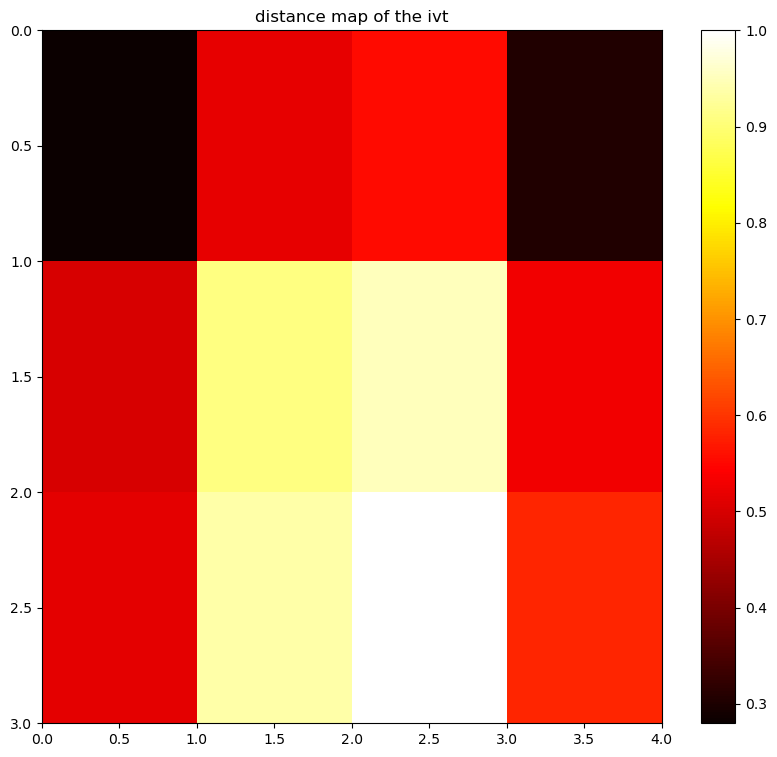

1546
[3 3 1 ... 2 2 3]
[0 2 0 ... 3 2 3]


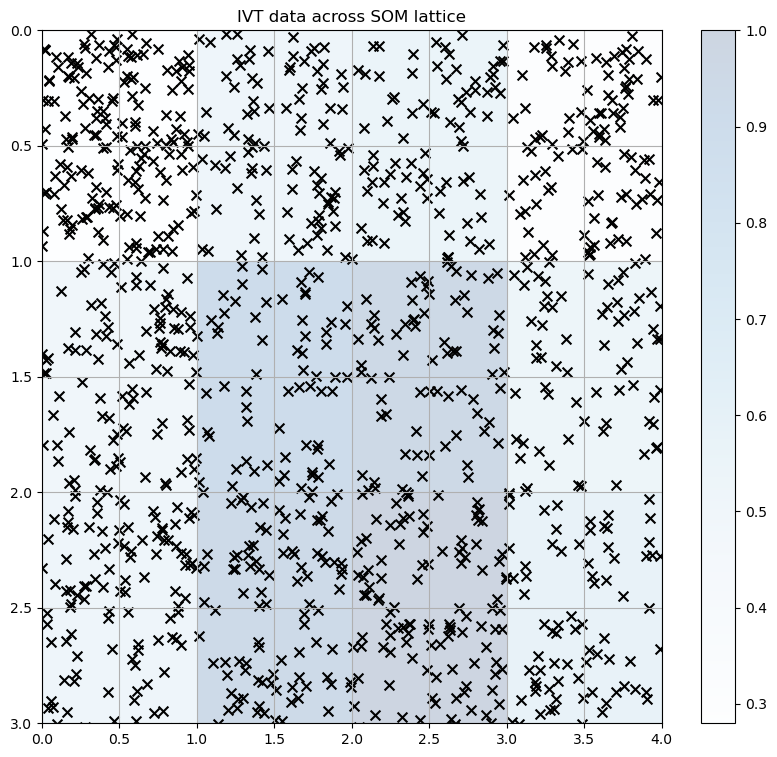

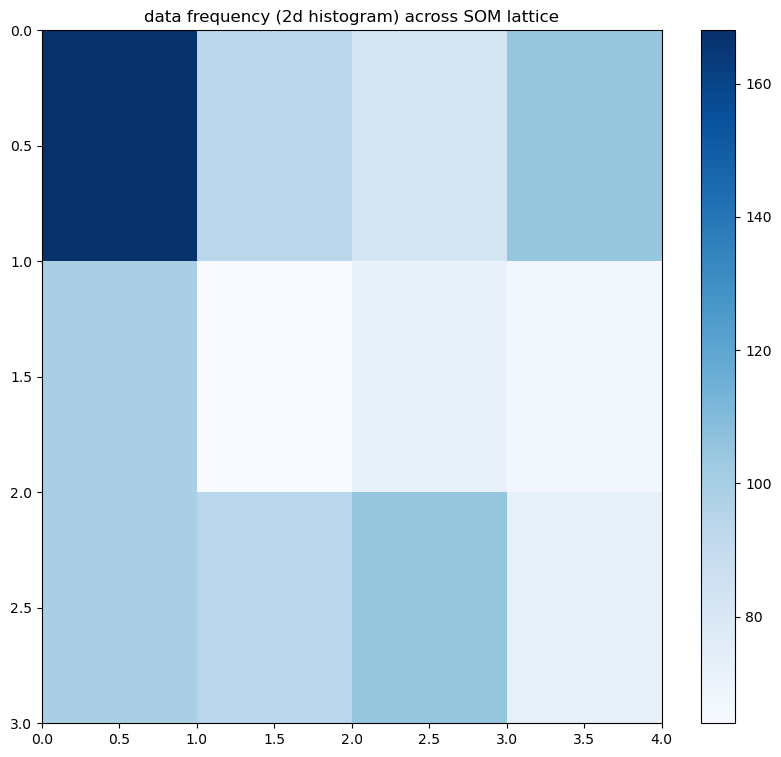

The rows and columns of the SOM lattice to use to grab SOM indexes:
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
Number of composite maps: 16


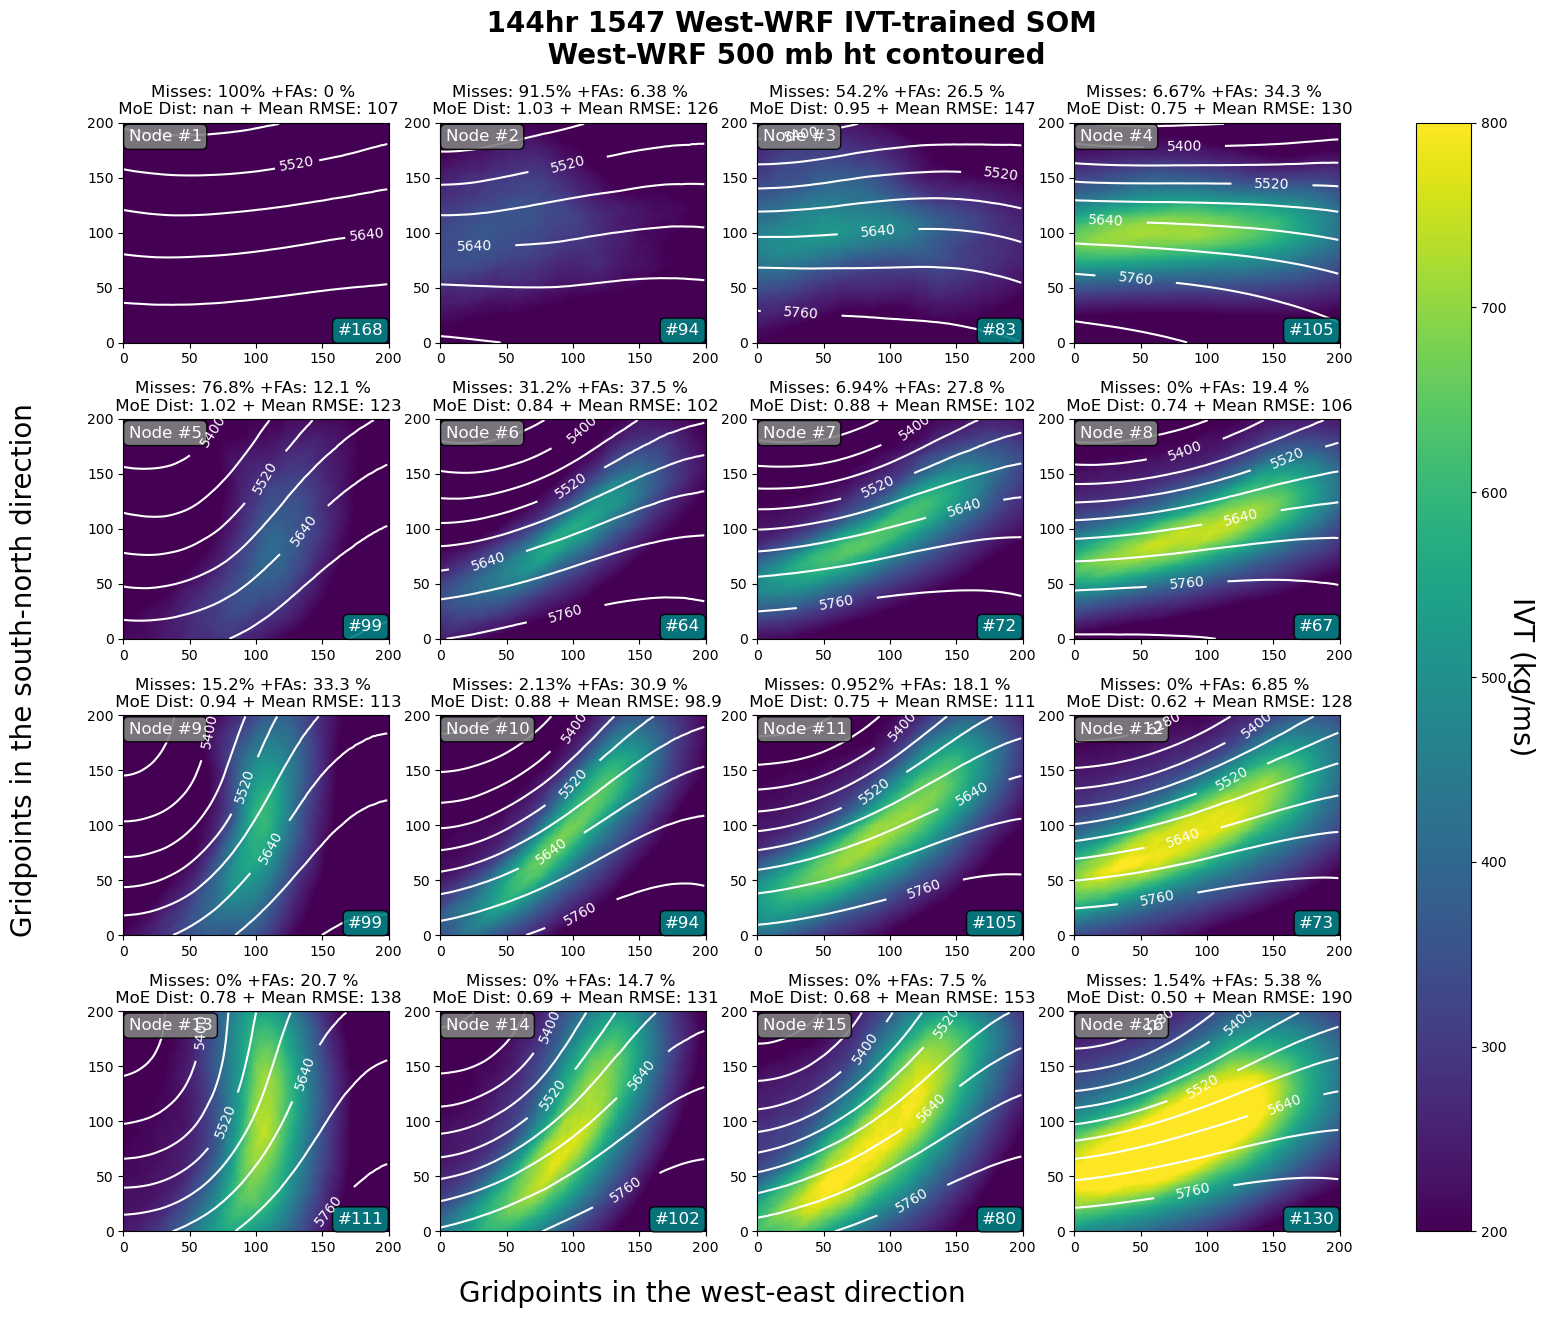

In [156]:
di_dates={}
som=newsom
if som==newsom:
    
        
        plt.figure(figsize=(10, 9))
        cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
        plt.title("distance map of the ivt", fontsize=12)
        plt.colorbar(cs)
        plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
        plt.show()


        # this may take a few minutes if lots of data! currently doing every 20th point so not bad

        # grab the x and y coords across the lattice for the winner node for each data point

        w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(ivt_plot_final).values])
        print(len(w_x))
        w_x = np.array(w_x)
        w_y = np.array(w_y)
        print(w_x)
        print(w_y)

        # visualize where data falls in lattice (nearest winning neuron/node)

        plt.figure(figsize=(10, 9))
        plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
        plt.colorbar()

        for num, c in enumerate(w_x[::1]):     # every 20th data point

            plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                        w_x[num] + np.random.rand(1),
                        s=50, c='k', marker='x')

        plt.title("IVT data across SOM lattice", fontsize=12)
        plt.margins(x=0,y=0)
        plt.grid()
        plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
        plt.show()



        plt.figure(figsize=(10, 9))
        frequencies = newsom.activation_response(normalize_data(ivt_plot_final).values)
        plt.pcolormesh(frequencies, cmap='Blues') 
        plt.colorbar()
        plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
        plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
        plt.show()

        # grabbing indices from SOM
        #all the cases for 2016-2017 500 mb heights are fairly similar 
        # create an empty dictionary using the rows and columns of SOM
        keys = [i for i in product(range(4),range(4))]
        winmap = {key: [] for key in keys}

        # grab the indices for the data within the SOM lattice
        for i, x in enumerate(normalize_data(ivt_plot_final).values):
            winmap[newsom.winner(x)].append(i)

        print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
        som_keys = list(winmap.keys())
        print(som_keys)
        print(f"Number of composite maps: {len(som_keys)}")


        ##plot som##
        fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))




        # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
        for map_num in range(len(som_keys)):

#             diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
#             fcst_data=all_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             obs_data=all_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
            ivt_data = ivt_plot_final[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
            rmse_data=np.mean(dict_rmse[som_keys[map_num]])
            dist_data=dist_all_sorted['variable'][dist_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pv_data=pv[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
#             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
            ht500=ht_plot_final[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pvplot=np.where(pv_data>.40,pv_data,np.nan)
#         #         pvplot=np.where(pv_data>.40,pv_data,np.nan)

        #         ivt_era=era5ss_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        #         ivt_wwrf=regridwrf_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

            di_dates[som_keys[map_num][0],som_keys[map_num][1]]=ivt_plot_final['time'][np.array(winmap[som_keys[map_num]])]
            
            projection = ccrs.PlateCarree()
            axs_class = (GeoAxes,
            dict(map_projection=projection))
            
            g=[]
            di_misses_v2={}
            for m in miss_new['time'].values:
                for key in di_dates:
                                #print(key)
                    if m in di_dates[key]:
                                    
                        if key not in di_misses_v2.keys():
                                    di_misses_v2.update({key:m})
                        else:
                                di_misses_v2[key] = di_misses_v2[key],m

                        g.append(key)
            e=[]
            fa_dict={}
            for f in fa_new['time'].values:
                for key in di_dates:
                    if f in di_dates[key]:
                            if key not in fa_dict.keys():
                                    fa_dict.update({key:f})
                            else:
                                    fa_dict[key] = fa_dict[key],f

                            e.append(key)


            new_dict=Counter(g)
            new_dict_fa=Counter(e)

            font = {
                    'color':  'white',
                    'weight': 'normal',
                    'size': 12,
                    }
            


#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
            label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_data,vmin=200, vmax=800,cmap='viridis')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


            n=(frequencies.flatten()[map_num])
        #         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

            #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
#             fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
#             obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
            htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='white',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]) #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
            geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f"Misses:{new_dict[som_keys[map_num][0],som_keys[map_num][1]]/frequencies[som_keys[map_num][0],som_keys[map_num][1]]*100: .3g}% +FAs:{new_dict_fa[som_keys[map_num][0],som_keys[map_num][1]]/frequencies[som_keys[map_num][0],som_keys[map_num][1]]*100: .3g} % \n MoE Dist: {dist_data.values:.2f} + Mean RMSE: {rmse_data:.3g}", fontsize=12)
            #+ Mean RMSE: {rmse_data:.3g}
            #geo_axs[som_keys[map_num][0], som_keys[map_num][1]].text(15.5, 2, f"Node #{map_num + 1}",transform=geo_axs[som_keys[map_num][0], som_keys[map_num][1]].transAxes,fontdict=font, ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))
#             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')
            plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='white')

        #                    
#             plt.clabel(fcstctr,fmt='%1.0f',colors='black')
#             plt.clabel(obsctr,fmt='%1.0f',colors='green')
        #         # plot the figure containing all plots
        
            props_gray = dict(boxstyle='round', facecolor='gray', alpha=0.9, edgecolor='black')
            props_teal = dict(boxstyle='round', facecolor='teal', alpha=.9)

            geo_axs[som_keys[map_num][0], som_keys[map_num][1]].text(0.02, .97, f"Node #{map_num + 1}", bbox=props_gray, fontdict=font,transform=geo_axs[som_keys[map_num][0], som_keys[map_num][1]].transAxes,ha='left', va='top')
            geo_axs[som_keys[map_num][0], som_keys[map_num][1]].text(.98, 0.02, f"#{int(frequencies.flatten()[map_num])}", bbox=props_teal, fontdict=font,transform=geo_axs[som_keys[map_num][0], som_keys[map_num][1]].transAxes,ha='right', va='bottom')
            plt.subplots_adjust(left=0.1, bottom=.1, right=0.5, top=.7, wspace=0.1, hspace=0.1)
            
#             props = dict(boxstyle='round', facecolor='teal', alpha=.9)  
#             geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(0.03,10,f" #{[map_num]}",bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'),fontdict=font)
#             geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(5.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
#             plt.subplots_adjust(left=0.1,
#                     bottom=.1, 
#                     right=0.5, 
#                     top=.9, 
#                     wspace=0.1, 
#                     hspace=0.1)


        plt.tight_layout()
        fig = plt.gcf()
        fig.suptitle(" 144hr 1547 West-WRF IVT-trained SOM \n West-WRF 500 mb ht contoured".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
        #ax1=fig.colorbar(label, ax=fig.get_axes())
        cbar=fig.colorbar(label, ax=fig.get_axes())
#         cbar.ax.set_ylabel('IVT (kg/ms)', rotation=270, fontsize=20,labelpad=20
#               )
        fig.text(-0.03, 0.5, 'Gridpoints in the south-north direction', fontsize=20, ha='center', va='center', rotation=90)


        fig.text(.4,-.02,'Gridpoints in the west-east direction', fontsize=20, ha='center', va='center')

        cbar.ax.set_ylabel('IVT (kg/ms)', rotation=270, fontsize=20,labelpad=20
      )

        plt.show()


In [ ]:
ivt_plot_final

In [ ]:
ivt_plot_new['variable'][mask_ivt][np.array(winmap[som_keys[0]])].plot(col="time", col_wrap=6,vmin=200,vmax=800)

In [ ]:
new_dict

In [ ]:
new_dict_fa

In [ ]:
# di_dates={}
som=newsom
if som==newsom:
    
        
        plt.figure(figsize=(10, 9))
        cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
        plt.title("distance map of the ivt", fontsize=12)
        plt.colorbar(cs)
        plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
        plt.show()


        # this may take a few minutes if lots of data! currently doing every 20th point so not bad

        # grab the x and y coords across the lattice for the winner node for each data point

        w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(ivt_plot_final).values])
        print(len(w_x))
        w_x = np.array(w_x)
        w_y = np.array(w_y)
        print(w_x)
        print(w_y)

        # visualize where data falls in lattice (nearest winning neuron/node)

        plt.figure(figsize=(10, 9))
        plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
        plt.colorbar()

        for num, c in enumerate(w_x[::1]):     # every 20th data point

            plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                        w_x[num] + np.random.rand(1),
                        s=50, c='k', marker='x')

        plt.title("IVT data across SOM lattice", fontsize=12)
        plt.margins(x=0,y=0)
        plt.grid()
        plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
        plt.show()



        plt.figure(figsize=(10, 9))
        frequencies = newsom.activation_response(normalize_data(ivt_plot_final).values)
        plt.pcolormesh(frequencies, cmap='Blues') 
        plt.colorbar()
        plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
        plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
        plt.show()

        # grabbing indices from SOM
        #all the cases for 2016-2017 500 mb heights are fairly similar 
        # create an empty dictionary using the rows and columns of SOM
        keys = [i for i in product(range(4),range(4))]
        winmap = {key: [] for key in keys}

        # grab the indices for the data within the SOM lattice
        for i, x in enumerate(normalize_data(ivt_plot_final).values):
            winmap[newsom.winner(x)].append(i)

        print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
        som_keys = list(winmap.keys())
        print(som_keys)
        print(f"Number of composite maps: {len(som_keys)}")


        ##plot som##
        fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))




        # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
        for map_num in range(len(som_keys)):

#             diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
#             fcst_data=all_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             obs_data=all_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
            ivt_data = ivt_plot_final[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
            rmse_data=np.mean(dict_rmse[som_keys[map_num]])
            dist_data=dist_all['variable'][mask_dist][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pv_data=pv[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
#             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
            ht500=ht_all_new['variable'][mask_ivt_new][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pvplot=np.where(pv_data>.40,pv_data,np.nan)
#         #         pvplot=np.where(pv_data>.40,pv_data,np.nan)

        #         ivt_era=era5ss_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        #         ivt_wwrf=regridwrf_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

#             di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]
            
            projection = ccrs.PlateCarree()
            axs_class = (GeoAxes,
            dict(map_projection=projection))
            
            g=[]
            di_misses_v2={}
            for m in miss_new['variable'].values:
                for key in di_dates:
                                #print(key)
                    if m in di_dates[key]:
                                    
                        if key not in di_misses_v2.keys():
                                    di_misses_v2.update({key:m})
                        else:
                                di_misses_v2[key] = di_misses_v2[key],m

                        g.append(key)
            e=[]
            fa_dict={}
            for f in fa_new['variable'].values:
                for key in di_dates:
                    if f in di_dates[key]:
                            if key not in fa_dict.keys():
                                    fa_dict.update({key:f})
                            else:
                                    fa_dict[key] = fa_dict[key],f

                            e.append(key)


            new_dict=Counter(g)
            new_dict_fa=Counter(e)

            
            


#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
            label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_data,vmin=200, vmax=800,cmap='viridis')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


            n=(frequencies.flatten()[map_num])
        #         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

            #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
#             fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
#             obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
            htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='white',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]) #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
            geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f"Misses:{new_dict[som_keys[map_num][0],som_keys[map_num][1]]/frequencies[som_keys[map_num][0],som_keys[map_num][1]]*100: .3g}% +FAs:{new_dict_fa[som_keys[map_num][0],som_keys[map_num][1]]/frequencies[som_keys[map_num][0],som_keys[map_num][1]]*100: .3g} % \n MoE Dist: {dist_data.values:.2f} + Mean RMSE: {rmse_data:.3g}", fontsize=12)
            #+ Mean RMSE: {rmse_data:.3g}
#             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')
            plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='white')

        #                    
#             plt.clabel(fcstctr,fmt='%1.0f',colors='black')
#             plt.clabel(obsctr,fmt='%1.0f',colors='green')
        #         # plot the figure containing all plots
        
           
        
            font = {
                    'color':  'white',
                    'weight': 'normal',
                    'size': 11,
                    }
            
            props = dict(boxstyle='round', facecolor='teal', alpha=.9)           
            geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(15.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
            plt.subplots_adjust(left=0.1,
                    bottom=.1, 
                    right=0.5, 
                    top=.9, 
                    wspace=0.1, 
                    hspace=0.1)


        plt.tight_layout()
        fig = plt.gcf()
        fig.suptitle(" 144hr 1547 West-WRF IVT-trained SOM \n West-WRF 500 mb ht contoured".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
        #ax1=fig.colorbar(label, ax=fig.get_axes())
        cbar=fig.colorbar(label, ax=fig.get_axes())
#         cbar.ax.set_ylabel('IVT (kg/ms)', rotation=270, fontsize=20,labelpad=20
#               )
        fig.text(-0.03, 0.5, 'Gridpoints in the south-north direction', fontsize=20, ha='center', va='center', rotation=90)


        fig.text(.4,-.02,'Gridpoints in the west-east direction', fontsize=20, ha='center', va='center')

        cbar.ax.set_ylabel('IVT (kg/ms)', rotation=270, fontsize=20,labelpad=20
      )

        plt.show()


In [ ]:
ivt_plot_final

In [ ]:
ivt_plot_final.sel(time='2005-12-29')

In [ ]:
miss_new['variable'].sel(time='2005-12-29')

In [ ]:
fa_new['variable'].sel(time='2005-12-29')

In [ ]:
di_dates[3,3]

In [ ]:
mask_mfw=di_dates[3,3].isin(landfmt)

In [ ]:
di_dates[3,3][mask_mfw]

In [ ]:
regridwrf_unmatch['variable'][np.array(winmap[som_keys[11]])].plot(col='time',col_wrap=4,vmin=200,vmax=1000)

In [ ]:


min_lat = 30.995 
max_lat = 45.05 
max_lon = -129.50 
min_lon = -120.55 

In [ ]:
slice(min_lon,max_lon)

In [ ]:
era5ss_unmatch['variable'][np.array(winmap[som_keys[11]])].plot(col='time',x='lon',y='lat',\
                                                                col_wrap=4,vmin=200,vmax=1000)

In [ ]:
era5ss_unmatch['variable'].sel(time='1996-02-15').plot(x='lon',y='lat')

In [ ]:
total_era=xr.open_dataset('/cw3e/mead/projects/cdd105/2023.03.26_from_PJM/Reanalysis/ERA5/IVT/1996/ERA5_IVT_19960215.nc')

In [ ]:
total_wrf=xr.open_dataset('/cw3e/mead/projects/cdd105/30Year_Verif_from_PJM/2007-2008/2008012100/d01/cf/wrfcf_d01_2008-01-27_00_00_00.nc')

In [ ]:
 #Get IVT
    
lats=total_wrf['lat']
lons=total_wrf['lon']
new_lons = np.where(lons > 0, lons - 360, lons)
ivt = total_wrf['IVT'].isel(time=0)

#Plot the IVT 

fig = plt.figure(figsize=(20,16))
ax = plt.axes(projection= ccrs.PlateCarree(central_longitude=-155))
ax.set_extent([-175, -120, 20, 45], crs = ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines

ivt_levels = np.arange(250, 1000, 10)
cs = ax.contourf(new_lons, lats.values, ivt,levels=ivt_levels, cmap='viridis',transform=ccrs.PlateCarree())

#Add a colorbar
ivt_cbar = plt.colorbar(cs, orientation = 'horizontal')
ivt_cbar.set_label("IVT (kg $m^{-1}$$s^{-1}$)", fontsize = 16)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top labels
gl.right_labels=False 
ax.set_title('WRF IVT at '+str(ivt['time'].values))
#plt.savefig('WRF IVT at '+ ivt['time']+'.png')
plt.show()



In [ ]:
 #Get IVT
    
lats=total_era['lat']
lons=total_era['lon']
new_lons = np.where(lons > 0, lons - 360, lons)
ivt = total_era['IVT'].isel(time=0)

#Plot the IVT 

fig = plt.figure(figsize=(20,16))
ax = plt.axes(projection= ccrs.PlateCarree(central_longitude=-155))
ax.set_extent([-175, -120, 20, 45], crs = ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines

ivt_levels = np.arange(250, 1000, 10)
cs = ax.contourf(new_lons, lats.values,ivt,levels=ivt_levels, cmap='viridis',transform=ccrs.PlateCarree())

#Add a colorbar
ivt_cbar = plt.colorbar(cs, orientation = 'horizontal')
ivt_cbar.set_label("IVT (kg $m^{-1}$$s^{-1}$)", fontsize = 16)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top labels
gl.right_labels=False 
ax.set_title('ERA IVT at '+str(ivt['time'].values))
#plt.savefig('ERA IVT at '+ ivt['time']+'.png')
plt.show()

In [ ]:
miss_new['variable'].sel(time='2015-03-05')

In [ ]:
fa_new['variable'].sel(time='2007-01-18')